[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'Cumulative Strategy Returns'}, xlabel='Date'>

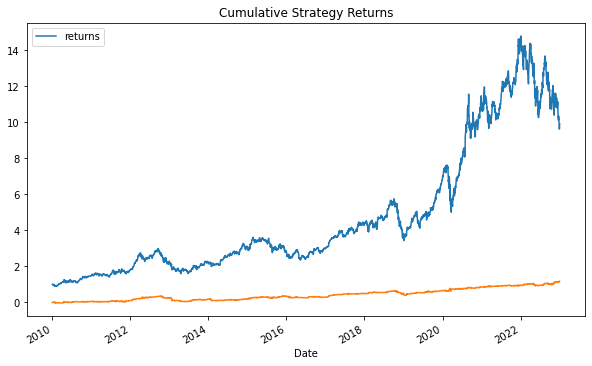

In [36]:
import numpy as np
import pandas as pd
import yfinance as yf
from pykalman import KalmanFilter

# Download historical price data for AAPL
aapl = yf.download('AAPL', start='2010-01-01', end='2022-12-31')

# Define the Kalman filter parameters
initial_state_mean = [aapl['Close'].iloc[0],0]
transition_matrix = [[1,1],[0,1]]
observation_matrix = [[1,0]]
observation_covariance = 1.0
transition_covariance = np.eye(2) * 0.001
initial_state_covariance = np.eye(2) * 0.001

# Create the Kalman filter object
kf = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  observation_covariance = observation_covariance,
                  transition_covariance = transition_covariance,
                  initial_state_mean = initial_state_mean,
                  initial_state_covariance = initial_state_covariance)

# Use the Kalman filter to estimate the true price of AAPL
a, _ = kf.filter(aapl['Close'].values)
aapl['kf_price']=pd.Series(a[:,0], index=aapl.index)
# Create a new column that indicates whether we should buy, sell or hold AAPL
aapl['signal'] = np.where(aapl['Close'] < aapl['kf_price'], 'buy',
                          np.where(aapl['Close'] > aapl['kf_price'], 'sell', 'hold'))

# Backtest the trading strategy
aapl['returns'] = np.log(aapl['Close'] / aapl['Close'].shift(1))
aapl['strategy_returns'] = aapl['returns'] * (aapl['signal'].shift(1) != aapl['signal'])
aapl['cumulative_strategy_returns'] = aapl['strategy_returns'].cumsum()

# Plot the results
#aapl[['Close', 'kf_price']].plot(figsize=(10,6), title='AAPL Close Price vs. Kalman Filter Estimate')
(aapl[['returns']]+1).cumprod().plot(figsize=(10,6), title='AAPL Long Only Strategy')
aapl['cumulative_strategy_returns'].plot(figsize=(10,6), title='Cumulative Strategy Returns')
